# Dreem Data Science Challenge
_Alain Soltani_

To have good performance and robustness on sleep staging and sound stimulation along the night (dreem headband purpose),     
we need to detect when the signal has good quality otherwise we could misinterpret the signals.    
The goal of this challenge is to use data-driven models to estimate the quality of EEG measurements.

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")
%matplotlib inline

## I. Import data
Import data from HDF5 files into Pandas dataframes.

In [2]:
hf = h5py.File("quality_dataset.h5", 'r')
print "List of arrays in this file:", hf.keys()

List of arrays in this file: [u'dataset', u'feature_descriptipn']


In [3]:
quality_frame = pd.DataFrame(np.array(hf["dataset"]), columns=np.array(hf["feature_descriptipn"]))
quality, quality_target = quality_frame.iloc[:, :-1], quality_frame.iloc[:, -1].astype(np.int32)
%xdel quality_frame

hf.close()

In [4]:
raw_col, filtered_col = quality.columns[:500], quality.columns[500:]

Visualize results obtained for various sensors, efficient or not.

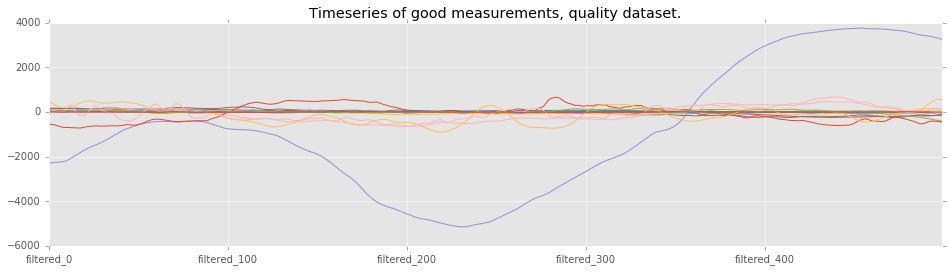

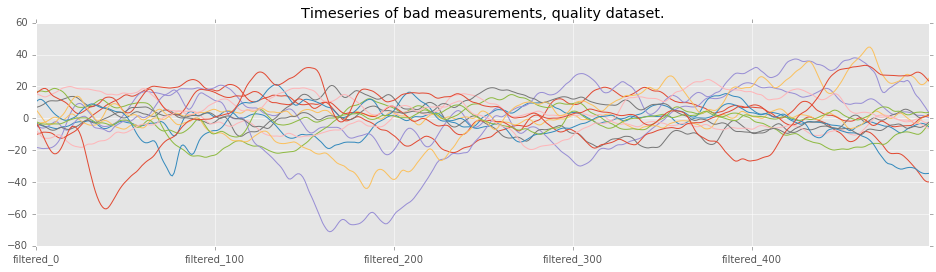

In [5]:
quality_good = quality[filtered_col].loc[quality_target == 1]
quality_bad = quality[filtered_col].loc[quality_target == 0]

plt.figure()
for i in xrange(15):
    quality_good.iloc[i].plot(figsize=(16, 4), 
                              title="Timeseries of good measurements, quality dataset.");
    
plt.figure()
for i in xrange(15):
    quality_bad.iloc[i].plot(figsize=(16, 4), 
                             title="Timeseries of bad measurements, quality dataset.");

%xdel quality_good
%xdel quality_bad

In [6]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(quality[filtered_col], quality_target, 
                                                    test_size=0.2, random_state=42)

## II. Classification Model

#### Model & parameter selection

To select the best parameters for this classification task, we will classically use a $\textsf{GridSearchCV}$ to choose them via cross-validation. As this task could be quite long, I didn't currently select the very best, but simply placed the framework here to be run later.

#### Score employed

A few words about the scoring method employed here : we want to avoid, as much as possible, a Type II error prediction (false negative error), i.e. failing to detect when a measurement is of bad quality. For this, a suitable scoring function is the precision score : the ratio $\frac{t_p}{t_p + f_p}$ where $t_p$ is the number of true positives and $f_p$ the number of false positives. It is intuitively the ability of the classifier not to label as positive a sample that is negative.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC

precision_scorer = make_scorer(precision_score)

grid = GridSearchCV(RandomForestClassifier(), param_grid={'n_estimators': [1, 2]},
                    scoring=precision_scorer)

grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
clf = grid

#clf = RandomForestClassifier()
#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)

print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.79      0.95      0.86     14969
          1       0.92      0.69      0.79     12437

avg / total       0.85      0.83      0.83     27406



## III. Prediction of record timestamps

#### General concept

My initial idea for record timestamp prediction was the following :
- store the raw/filtered record as a 4-column Pandas dataframe
- for each sensor column, run a sliding subframe of length 500 (i.e. the size of each measurement from the training set) row after row, and compute a new prediction for each one of the subframes seen. In short, each subframe is a timeseries, providing a prediction value we store for the entire set of indexes.
- to obtain the final prediction, we can average the predictions made row after row ; a solution for this is to create a $500 \times (len(training\_set) - 500)$ matrix, store prediction in each column, starting at index $i$ (unseen indexes being set to NaN), and average over $axis=1$.     
- However, this initial approach revealed being untractable, logically creating quick memory errors. Hence, I simply used the last value predicted over the set of indexes as a result. 

#### Dataset employed

Here, we have the choice between using a set of labels indicating a bad result vs. no information (**record1_bad_quality.csv**), or a a good result vs. no information (**record1_good_quality.csv**). It is important to mention that there is no linear combination between the two datasets here.     
Here, it seems more logical to employ the set of bad quality labels, and measure the accuracy of predictions, to assert our ability to predict accurately a bad signal (the equivalent problem for good signal is less risky for the customer).

In [8]:
from easy_import import extract_signals

raws, filtered = extract_signals("record1.h5")
raws, filtered = pd.DataFrame(raws.T), pd.DataFrame(filtered.T)
raws.columns = filtered.columns = ["Channel " + str(i + 1) for i in xrange(4)]

results = pd.DataFrame(np.zeros(raws.shape))
results.columns = ["Channel " + str(i + 1) for i in xrange(4)]

In [9]:
record_bad = pd.read_csv("record1_bad_quality.csv")
record_bad.columns = ["Channel " + str(i + 1) for i in xrange(4)]

In [ ]:
limit = 200
len_chunk = len(raw_col)

for idx in xrange(limit):
    
    sliding = clf.predict(record_bad["Channel 1"].iloc[idx: idx + len_chunk].reshape(1, -1))[0]
    results[idx: idx + len_chunk] = sliding

In [ ]:
from sklearn.metrics import accuracy_score
print accuracy_score(record_bad["Channel 1"].iloc[:limit + len_chunk], results["Channel 1"].iloc[:len_chunk + limit])